In [1]:
## Importing Python Necessary Modules ##

from load_data import read_data
import math
import copy
import numpy as np
import jax
import jaxlib
import jax.numpy as jnp
import matplotlib.pyplot as plt
import transforms3d as t
from jax.config import config
import pickle
import pandas as pd
from tqdm import tqdm
from jax.config import config
config.update("jax_enable_x64", True)





Data import took: 0.0008623600006103516 sec.



In [6]:
print(np.__version__)
print(jax.__version__)
# print(matplotlib.__version__)
print(pd.__version__)
print(t.__version__)

1.21.5
0.4.2
1.5.3
0.4.1


In [81]:


## Comment the vicon dictionary variable in case the vicon data is not available ##


jnp.set_printoptions(threshold=np.inf)
imu=read_data('/home/prithwiraj/Desktop/ECE276A_PR1/ECE276A_PR1/data/imu/imuRaw1.p')
vicon=read_data('/home/prithwiraj/Desktop/ECE276A_PR1/ECE276A_PR1/data/vicon/viconRot1.p')

imu_data_biased=jnp.float_(imu['vals'])
imu_data_timestamp=imu['ts']





In [82]:

# IMU CALIBRATION

Vref=3300 # mV  (Reference Voltage for A/D Converter)
sens_acc=300 #mV/g (max =330, min=270) (Sensitivity for Accelerometer)
scale_factor_acc=(Vref/1023)/sens_acc  #scale factor for accelerometer


Vref_gyro=3000 #mV (Reference Voltage for A/D Converter)
sens_gyro=3.33 #mV/deg/sec (Sensitivity for Gyroscope : 4x signal)
scale_factor_gyro=((Vref_gyro/1023)/sens_gyro)*(math.pi/180)  #scale factor for gyroscope
print(scale_factor_gyro)
g=9.81

imu_data_biased = imu_data_biased.at[:3,:].set(imu_data_biased[:3,:]*float(scale_factor_acc))
imu_data_biased = imu_data_biased.at[3:6,:].set(imu_data_biased[3:6,:]*float(scale_factor_gyro))


0.01537017297644562


In [83]:
# OBSERVATIONS from VICON ground-truth data


# Body is stationary for the first 700 timestamps so the average of 1st 700 timestamps data is taken as bias 

imu_data=jnp.empty(imu_data_biased.shape)

# Removing Bias from each term (acceleration and gyroscope)

### Bias Value for Given Dataset

# Dataset 1: Average of first 700 timestamps data
# Dataset 2: Average of first 700 timestamps data
# Dataset 3: Average of first 700 timestamps data
# Dataset 4: Average of first 400 timestamps data
# Dataset 5: Average of first 450 timestamps data
# Dataset 6: Average of first 450 timestamps data
# Dataset 7: Average of first 450 timestamps data
# Dataset 8: Average of first 500 timestamps data
# Dataset 9: Average of first 300 timestamps data

## TEST DATA
# Dataset 10: Average of first 400 timestamps data
# Dataset 11: Average of first 400 timestamps data

n_samples=700


i=0
while i<6:
    if i==2:
        imu_data = imu_data.at[i,:].set(imu_data_biased[i,:]-jnp.average(imu_data_biased[i,:n_samples])+1)  # adding +1 to the Az term and subtracting the average of first 700 timestamps to ensure acceleration 'g' in Z axis in world frame
    else:
        imu_data = imu_data.at[i,:].set(imu_data_biased[i,:]-jnp.average(imu_data_biased[i,:n_samples]))
    i=i+1

# IMU Ax and Ay direction is flipped (due to device design), so positive acceleration in body frame will result in negative acceleration reported by the IMU.
imu_data = imu_data.at[0,:].set(-imu_data[0,:])
imu_data = imu_data.at[1,:].set(-imu_data[1,:])

imu_data_cal=copy.deepcopy(imu_data)



In [84]:
#COMPUTING TIME DIFFERENCE (tau) FROM TIMESTAMPS

imu_data_time=jnp.empty([1,imu_data_timestamp.shape[1]])
i=1
while i<imu_data_time.shape[1]:
    imu_data_time = imu_data_time.at[0,i].set(imu_data_timestamp[0,i]-imu_data_timestamp[0,i-1])
    i=i+1


In [85]:
# computing the quaternion trajectory using the prediction model

@jax.jit
def qmult(q,p):
    '''
    Function performes quaternion multiplication operation
    Input params: q and p (two quaternions)
    Input param type: jax numpy array
    '''
    res = jnp.array(q[0]*p[1:4]+p[0]*q[1:4]+jnp.cross(q[1:4],p[1:4]))
    res = jnp.insert(res,0,q[0]*p[0]-jnp.dot(q[1:4],p[1:4]))
    return res
    
@jax.jit
def qinverse(q):
    '''
    Function performes quaternion inverse operation
    Input param: q (one quaternion)
    Input param type: jax numpy array
    '''
    #q=q.at[1:4].set(q[1:4]+math.pow(10,-4))
    res = jnp.array([-1*i for i in q[1:4]])
    res = jnp.insert(res,0,q[0])
    res = res/(jnp.linalg.norm(res))**2
    return res
@jax.jit
def qlog(q):
    '''
    Function performes quaternion log operation
    Input param: q (one quaternion)
    Input param type: jax numpy array

    '''
    q=q.at[1:4].set(q[1:4]+math.pow(10,-3))
    #q[1:4]=q[1:4]#+math.pow(10,-6)
    res = (q[1:4]/(jnp.linalg.norm(q[1:4])))*jnp.arccos(q[0]/(jnp.linalg.norm(q)))
    res = jnp.insert(res,0,jnp.log(jnp.linalg.norm(q)))
    return res

@jax.jit
def qexp(q):
    '''
    Function performes quaternion exponential operation
    Input param: q (one quaternion)
    Input param type: jax numpy array

    '''
    mag=jnp.linalg.norm(q[1:4])
    res = (q[1:4])*jnp.sinc(mag/jnp.pi)
    #res = (q[1:4]/mag)*jnp.sin(mag)
    res = jnp.insert(res,0,jnp.cos(jnp.linalg.norm(q[1:4])))
    res = res*jnp.exp(q[0])
    return res

@jax.jit
def qnorm(q):

    '''
    Function performes quaternion norm operation
    Input param: q (one quaternion)
    Input param type: jax numpy array

    '''
    res = sum([i**2 for i in q])
    return jnp.sqrt(res)

@jax.jit
def obs_model(q):
    '''
    Function computes the acceleration vector in IMU frame given a quaternion (rotation from World frame to IMU frame)
    Input param: q (one quaternion)
    Input param type: jax numpy array
    '''
    h1 = qmult(qinverse(q),qmult(jnp.array([0,0,0,1]),q))
    return h1



In [86]:
# Trajectory Prediction using Quaternion Kinematics Motion Model

# Initializing the quaternion trajectory matrix

q_traj_pred=jnp.empty([imu_data_time.shape[1],4],dtype=jnp.float64)

q_traj_pred = q_traj_pred.at[0,:].add([1.,0.,0.,0.])

angle_rads=jnp.vstack([jnp.zeros([1,imu_data_time.shape[1]]),0.5*imu_data_time[0,:]*imu_data_cal[4,:],0.5*imu_data_time[0,:]*imu_data_cal[5,:],0.5*imu_data_time[0,:]*imu_data_cal[3,:]])
q_exp_q=jnp.apply_along_axis(qexp,1,angle_rads.T)

for i in range(1,imu_data_time.shape[1]):  
    q_traj_pred = q_traj_pred.at[i,:].add(qmult(q_traj_pred[i-1],q_exp_q[i-1]))


In [ ]:
###### COMPARISON OF PREDICTED EULER ANGLES WITH VICON GROUND-TRUTH DATA ######

# Predicting the euler angles from the predicted quaternions 
euler_predicted=jnp.empty([imu_data_time.shape[1],3])

for i in range(q_traj_pred.shape[0]):
    euler_predicted = euler_predicted.at[i,:].set(t.euler.quat2euler(q_traj_pred[i],'sxyz'))

# Computing the Ground-Truth Euler Angles from Vicon Data

rot_mat_vicon=jnp.float_(vicon['rots'])
euler_vicon=jnp.empty([rot_mat_vicon.shape[2],3])
for i in range(rot_mat_vicon.shape[2]):
    euler_vicon = euler_vicon.at[i,:].set(t.euler.mat2euler(rot_mat_vicon[:,:,i],'sxyz'))

# PLOTTING THE EULER ANGLES AND COMPARING WITH VICON DATA 

fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(15,15))
fig.suptitle('Comparison Plot of Predicted Euler Angles with VICON ground-truth data')

ax1.plot(euler_vicon[:,1]*180/jnp.pi,label='Ground-truth Euler Angle from Vicon')
ax1.legend(loc='upper right')
ax1.plot(euler_predicted[:,1]*180/jnp.pi,label='Predicted Euler Angle from Motion Model')
ax1.legend(loc='upper right')
ax1.set_title('Angle about Y axis')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Euler Angle in deg',)


ax2.plot(euler_vicon[:,2]*180/jnp.pi,label='Ground-truth Euler Angle from Vicon')
ax2.legend(loc='upper right')
ax2.plot(euler_predicted[:,2]*180/jnp.pi,label='Predicted Euler Angle from Motion Model')
ax2.legend(loc='upper right')
ax2.set_title('Angle about Z axis')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Euler Angle in deg',)

ax3.plot(euler_vicon[:,0]*180/jnp.pi,label='Ground-truth Euler Angle from Vicon')
ax3.legend(loc='upper right')
ax3.plot(euler_predicted[:,0]*180/jnp.pi,label='Predicted Euler Angle from Motion Model')
ax3.legend(loc='upper right')
ax3.set_title('Angle about X axis')
ax3.set_xlabel('time (s)')
ax3.set_ylabel('Euler Angle in deg',)

plt.savefig('Euler_comp_Vicon_initial_D9.png')



In [ ]:
###### COMPARISON OF ACCELERATION WITH IMU DATA ######


acc_pred_body=jnp.empty([imu_data_time.shape[1],4])

k=0
for q in q_traj_pred:
    acc_pred_body = acc_pred_body.at[k,:].set(qmult(qinverse(q),qmult(jnp.array([0,0,0,1]),q)))
    k=k+1


fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(15,15))
fig.suptitle('Comparison Plot of Predicted Acceleration using Observation Model with IMU accelerometer data')

ax1.plot(imu_data_cal[0,:], label='Acceleration measured by IMU')
ax1.legend(loc='upper right')
ax1.plot(acc_pred_body[:,1], label ='Acceleration predicted from observation model')
ax1.legend(loc='upper right')
ax1.set_title('Acceleration about X axis')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Acceleration in g unit',)


ax2.plot(imu_data_cal[1,:],label='Acceleration measured by IMU')
ax2.legend(loc='upper left')
ax2.plot(acc_pred_body[:,2],label ='Acceleration predicted from observation model')
ax2.legend(loc='upper left')
ax2.set_title('Acceleration about Y axis')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Acceleration in g unit')


ax3.plot(imu_data_cal[2,:],label='Acceleration measured by IMU')
ax3.legend(loc='upper left')
ax3.plot(acc_pred_body[:,3],label ='Acceleration predicted from observation model')
ax3.legend(loc='upper left')
ax3.set_title('Acceleration about Z axis')
ax3.set_xlabel('time (s)')
ax3.set_ylabel('Acceleration in g unit')

plt.savefig('Acc_comp_Vicon_initial_D9.png')


In [ ]:

## COST FUNCTION ##

obs_cost=[]
mot_cost=[]
total_cost=[]

def cost_func(q_traj):
    '''
    Cost Function: Function computes the total cost: Observation Model cost + Motion Model cost
    Input Param: Quaternion Array for entire time-series

    '''
    obs_model_err=0
    mot_model_err=0
    theta_rads=jnp.vstack([jnp.zeros([1,imu_data_time.shape[1]-1]),0.5*imu_data_time[0,1:]*imu_data_cal[4,1:],0.5*imu_data_time[0,1:]*imu_data_cal[5,1:],0.5*imu_data_time[0,1:]*imu_data_cal[3,1:]])
    q_exp_quat=jnp.apply_along_axis(qexp,1,theta_rads.T)
    q_inverse=jnp.apply_along_axis(qinverse,1,q_traj[2:])

  

    ## LOOP FOR MOTION MODEL COST ##
    for i in tqdm(range(1,q_traj.shape[0]-1)):

        #q_inv=qinverse(q_traj[i+1])
        c=qmult(q_traj[i],q_exp_quat[i-1])
        d=qmult(q_inverse[i-1],c)

        if jnp.array([0]*3).all() == d[1:4].all() and d[0]!=0:
            e=jnp.array([jnp.log(d[0]),d[1],d[2],d[3]])
        else:
            e=qlog(d)

        mot_model_err = mot_model_err + (jnp.linalg.norm(2*e))**2
    mot_cost.append(0.5*mot_model_err)
    
    ## OBSERVATION MODEL COST ##

    h = jnp.apply_along_axis(obs_model, 1, q_traj[1:,:])
    a1 = imu_data_cal[0:3,1:].T
    obs_model_err=jnp.linalg.norm(a1-h[:,1:4])**2
    obs_cost.append(0.5*obs_model_err)
    
    print(obs_model_err, mot_model_err)
    total_cost.append(0.5*obs_model_err + 0.5*mot_model_err)
    return 0.5 * (obs_model_err + mot_model_err)

## PROJECTED GRADIENT DESCENT ##

q_prev = copy.deepcopy(q_traj_pred)
alpha=0.05 #Learning Rate
res=jax.grad(cost_func)
i=0 # iteration count
n_iters=10

while i < n_iters:
    #cost_func(q_prev)
    print(i)

    q_iterated = q_prev - alpha * res(q_prev)

    # constraining the iterated quaternion to be unit quaternion\
    for j in range(q_iterated.shape[0]):
        q_iterated=q_iterated.at[j,:].set(q_iterated[j]/jnp.linalg.norm(q_iterated[j]))
    q_prev = copy.deepcopy(q_iterated)

    i = i + 1



In [ ]:
## PLOTTING THE COST FUNCTION ##

fig3 = plt.figure("Figure 3")

plt.plot([c.astype(np.int32) for c in obs_cost],label='Observation Model Cost')
plt.plot([(j*20).astype(np.int32) for j in mot_cost],label='Motion Model Cost')
plt.plot([i.astype(np.int32) for i in total_cost], label='Total Cost')
plt.legend(loc='upper right')
plt.title('Cost Function Value for Dataset 1')
plt.ylabel('Value of Cost Function')
plt.xlabel('Number of Iterations in Gradient Descent Optimization')
plt.savefig('Cost Value_D10.png')


#### PLOTTING THE OPTIMIZED EULER ANGLES AND COMPARISON WITH VICON GROUND-TRUTH DATA ####

k=0
euler_predicted=jnp.empty([imu_data_time.shape[1],3])
euler_optimized=jnp.empty([imu_data_time.shape[1],3])
for i in range(q_traj_pred.shape[0]):
    euler_predicted = euler_predicted.at[i,:].set(t.euler.quat2euler(q_traj_pred[i],'sxyz'))

for i in range(q_iterated.shape[0]):
    euler_optimized = euler_optimized.at[i,:].set(t.euler.quat2euler(q_iterated[i],'sxyz'))

a=vicon['rots']
euler=jnp.empty([a.shape[2],3])
for i in range(a.shape[2]):
    euler = euler.at[i,:].set(t.euler.mat2euler(a[:,:,i]))



fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(15,15))
fig.suptitle('Comparison plot of optimized Euler Angles with  VICON ground-truth data')


ax1.plot(euler[:,0]*180/jnp.pi,label='Euler Angle from Vicon data')
ax1.legend(loc='upper left')
ax1.plot(euler_optimized[:,0]*180/jnp.pi,label='Optimized Euler Angle')
ax1.legend(loc='upper left')
ax1.plot(euler_predicted[:,0]*180/jnp.pi,label='Predicted Euler Angle from Motion Model')
ax1.legend(loc='upper left')
ax1.set_title('Angle about X axis')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Euler Angle in deg')


ax2.plot(euler[:,1]*180/jnp.pi,label='Euler Angle from Vicon data')
ax2.legend(loc='upper left')
ax2.plot(euler_optimized[:,1]*180/jnp.pi,label='Optimized Euler Angle')
ax2.legend(loc='upper left')
ax2.plot(euler_predicted[:,1]*180/jnp.pi,label='Predicted Euler Angle from Motion Model')
ax2.legend(loc='upper left')
ax2.set_title('Angle about Y axis')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Euler Angle in deg')

ax3.plot(euler[:,2]*180/jnp.pi,label='Euler Angle from Vicon data')
ax3.legend(loc='upper left')
ax3.plot(euler_optimized[:,2]*180/jnp.pi,label='Optimized Euler Angle')
ax3.legend(loc='upper left')
ax3.plot(euler_predicted[:,2]*180/jnp.pi,label='Predicted Euler Angle from Motion Model')
ax3.legend(loc='upper left')
ax3.set_title('Angle about Z axis')
ax3.set_xlabel('time (s)')
ax3.set_ylabel('Euler Angle in deg')

plt.savefig('Optimized Euler Comparison Dataset 1.png')


  


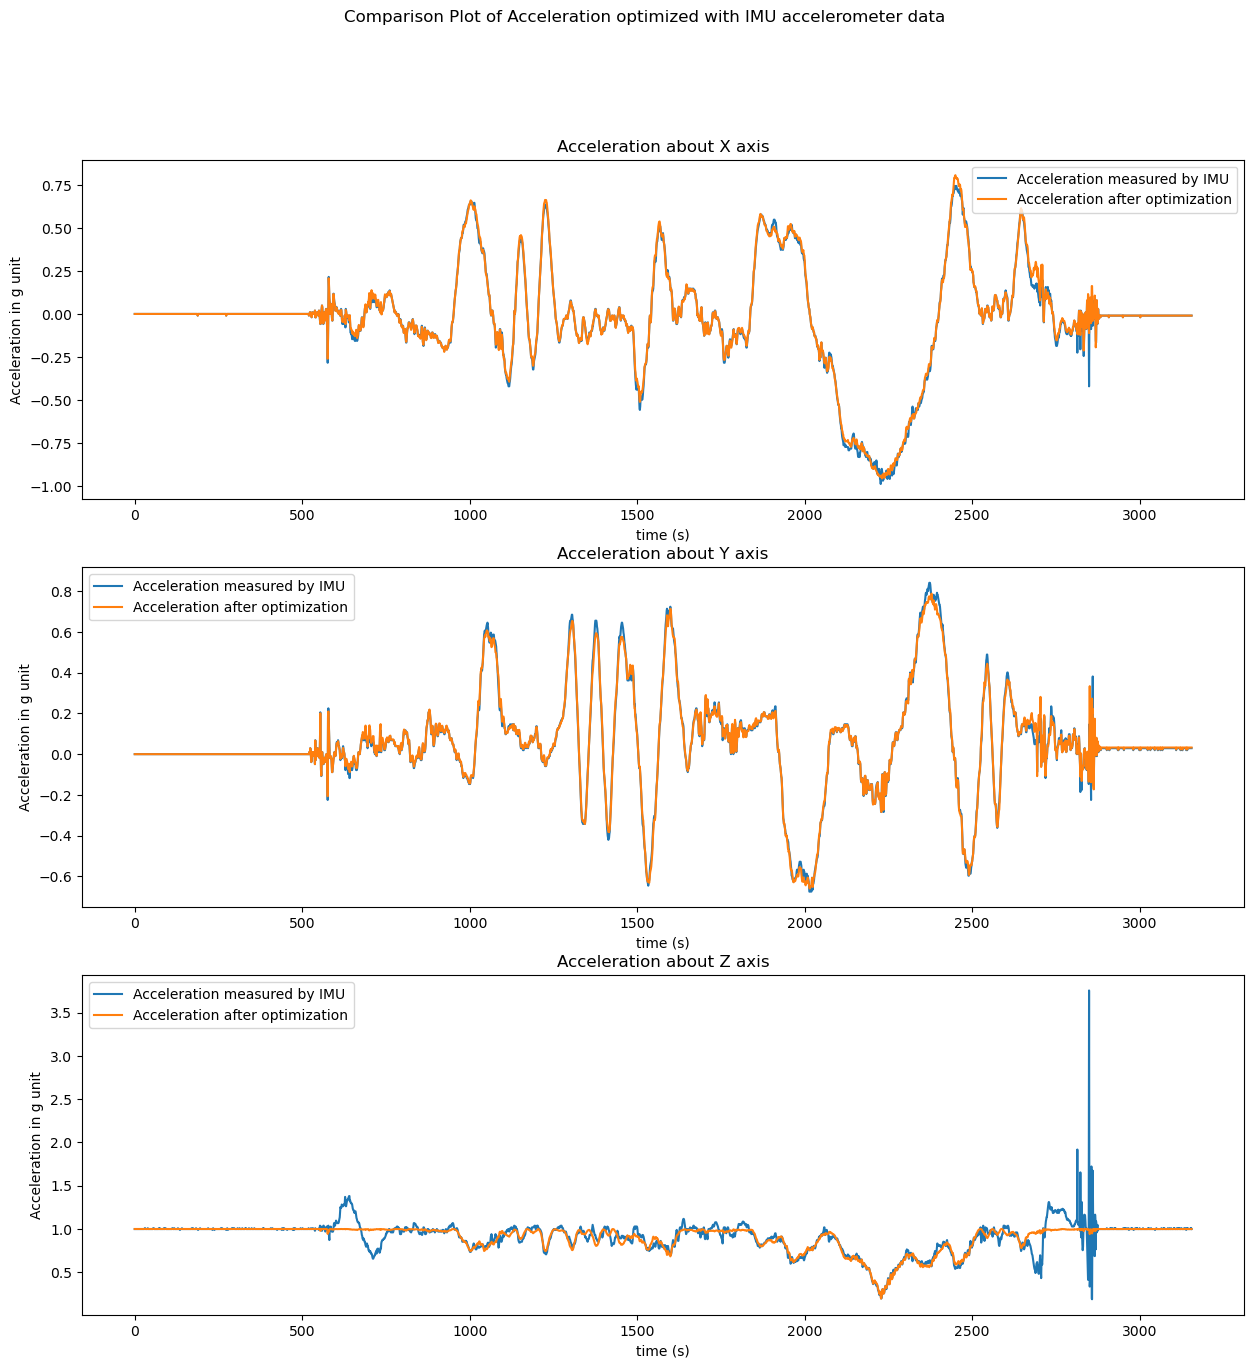

In [258]:
## OPTIMIZED ACCELERATION ##

acc_optimized_body=jnp.empty([imu_data_time.shape[1],4])

k=0
for q in q_iterated:
    acc_optimized_body = acc_optimized_body.at[k,:].set(qmult(qinverse(q),qmult(jnp.array([0,0,0,1]),q)))
    k=k+1


fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(15,15))
fig.suptitle('Comparison Plot of Acceleration optimized with IMU accelerometer data')

ax1.plot(imu_data_cal[0,:], label='Acceleration measured by IMU')
ax1.legend(loc='upper right')
ax1.plot(acc_optimized_body[:,1], label ='Acceleration after optimization')
ax1.legend(loc='upper right')
ax1.set_title('Acceleration about X axis')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Acceleration in g unit',)


ax2.plot(imu_data_cal[1,:],label='Acceleration measured by IMU')
ax2.legend(loc='upper left')
ax2.plot(acc_optimized_body[:,2],label ='Acceleration after optimization')
ax2.legend(loc='upper left')
ax2.set_title('Acceleration about Y axis')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Acceleration in g unit')


ax3.plot(imu_data_cal[2,:],label='Acceleration measured by IMU')
ax3.legend(loc='upper left')
ax3.plot(acc_optimized_body[:,3],label ='Acceleration after optimization')
ax3.legend(loc='upper left')
ax3.set_title('Acceleration about Z axis')
ax3.set_xlabel('time (s)')
ax3.set_ylabel('Acceleration in g unit')

plt.savefig('Acc_optimized_D4.png')

PANORAMA MODEL

In [88]:
## Loading the Camera Data ##

cam_data=read_data('/home/prithwiraj/Desktop/ECE276A_PR1/ECE276A_PR1/data/cam/cam1.p')
pixels=cam_data['cam']
rows=pixels.shape[0]
cols=pixels.shape[1]
time_data=cam_data['ts']


In [89]:
# COMPUTING THE SPHERICAL COORDINATES IF THE IMAGE #

image_matrix_spherical=jnp.empty([rows,cols,3])
del_width=(60/(cols-1))*(math.pi/180)
del_height=(45/(rows-1))*(math.pi/180)
R=1 # Assuming Depth of 1 unit
time_rot_dict={}

## This block should be commented if the VICON Data is NOT used ##

# vicon_time=vicon['ts']
# vicon_time=vicon_time.astype('float64')

# a=vicon['rots']
# a=a.astype('float64')
# vicon_time=vicon_time.tolist()

# for i in range(len(vicon_time[0])):
#     time_rot_dict[vicon_time[0][i]]=a[:,:,i]

## This block should be commented if Rotation Matrix from optimized quaternions is NOT computed ##

for i in range(imu_data_time.shape[1]):
    time_rot_dict[imu_data_timestamp[0][i]]=t.quaternions.quat2mat(q_iterated[i])





In [48]:
image_matrix_cart=jnp.empty([rows,cols,3])

#storing the images in a matrix
image_matrix_world=jnp.empty([3,rows*cols])


## Computing the spherical coordinates of each pixel assuming the image to be spherical ##

for i in range(rows):
    for j in range(cols):
        val=jnp.array([R,jnp.pi/6-j*del_width,jnp.pi*0.375+i*del_height])
        image_matrix_spherical = image_matrix_spherical.at[i,j].set(val)

## Computing the cartesian coordinates of each pixel in the chosen reference frame ##
  
k=0
for i in range(rows):
    for j in range(cols):
        theta=image_matrix_spherical[i][j][1]
        phi=image_matrix_spherical[i][j][2]
        X=R*jnp.sin(phi)*jnp.cos(theta)
        Y=R*jnp.sin(phi)*jnp.sin(theta)
        Z=R*jnp.cos(phi)
        vect=jnp.array([X,Y,Z])
        image_matrix_world = image_matrix_world.at[:,k].add(vect.T)
        k=k+1


In [90]:
def cart2lambert(v):
    '''
    Function converts cartesian coordinates in world frame to planar coordinates using Lambert Azimuthal Equal Area Projection
    Input v: array of x,y,z coordinate
    
    '''
    x, y, z = v
    X_plane=np.sqrt(2/(1-z))*x
    Y_plane=np.sqrt(2/(1-z))*y
    return [X_plane,Y_plane,1]

In [91]:
# converting the cartesian coordinates to the world frame

i=0
panorama_size=1000
image_panorama=np.zeros([panorama_size,panorama_size,3], dtype='uint8') # defining the panorama image size
imgl = []
scale_factor=250

## finding the closest time
time_index = {}
for t in time_data[0]:
  time_diff = np.abs(imu_data_timestamp[0] - t)
  index = np.argmin(time_diff)
  time_index[t] = index

while i < len(time_data[0]):# time stamp of camera

    # convert to world frame coordinates
    d = np.matmul(time_rot_dict[imu_data_timestamp[0][time_index[time_data[0][i]]]],image_matrix_world)

    # convert to lambert planar coordinates
    c = np.apply_along_axis(cart2lambert, 0, d)
    imgl.append(c)
    c=c*scale_factor # multiplying by a factor to scale up the resolution
    c = c.astype(np.int32)
    bias=np.min(c)
    
    #bias correction
    c-=bias # adding the bias term to the coordinates
    #c%=1200

    for j in range(c.shape[1]):

        ## assigning RGB pixel values at the respective coordinates in the panorama image
        image_panorama[-c[0,j], -c[1,j], :] = pixels[int(j//320),int(j%320),:,i]
    
    i=i+1



In [ ]:

from PIL import Image 
plt.imshow(image_panorama)

Image.fromarray(image_panorama).save("image_panorama_D1.png")